In [1]:
import tensorflow as tf
from model import Model

from dataLoader import PlantDiseaseDataLoader

In [2]:
height, width = 75, 75
data = PlantDiseaseDataLoader(width=width, modes=["full"], verbose=True)
data.loadDataset(drop_out=0)


DataLoader initialized with:
src_dir: e:\code\ml_survive\PlantVillage-Dataset/raw/segmented
width: 75
height: 75
mode: ['full']
Num GPUs Available:  1
Loaded 54306 images


1842 augmented images have been added to the data set!


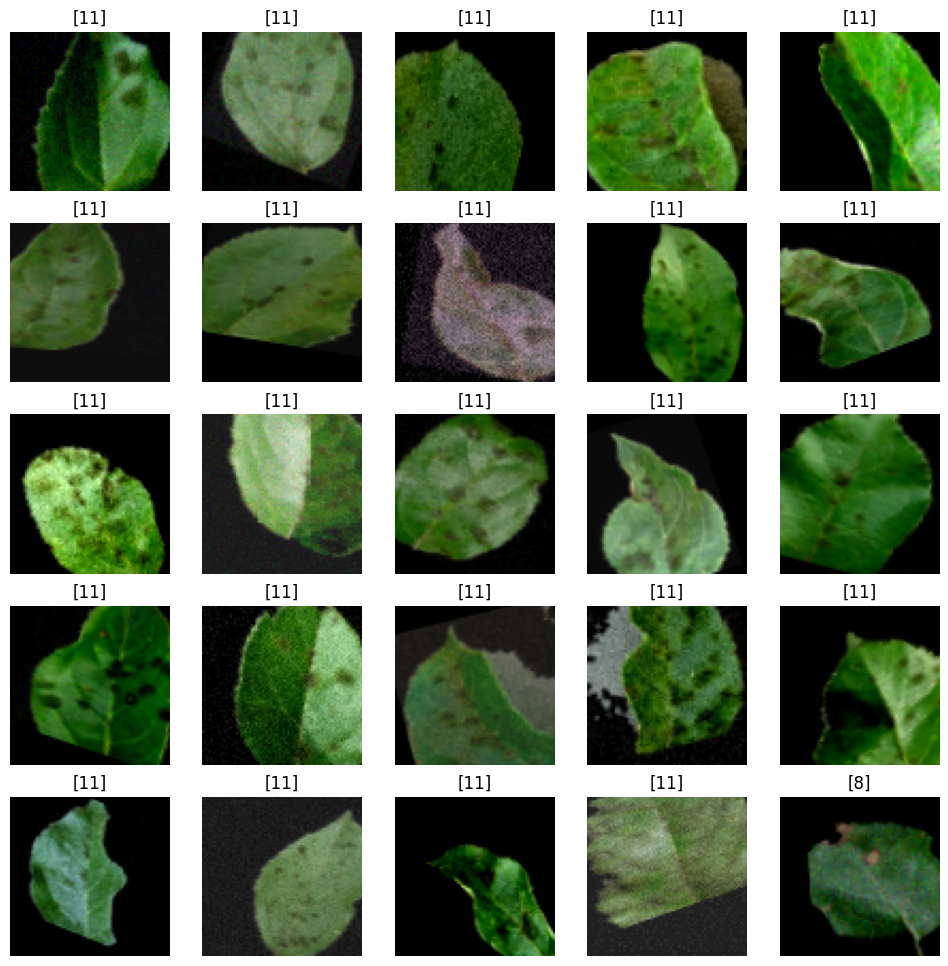

In [3]:
X_Train, X_Valid, X_Test, y_Train, y_Valid, y_Test = data.getSplitDataset()
data.augment_data(augmentation_factor=0.033556868432135706)
y_Train = y_Train[:,0]
y_Valid = y_Valid[:,0]
y_Test = y_Test[:,0]

Dict{dir_name: label_name}:
 {'Apple___Apple_scab': 'Apple___Apple_scab', 'Apple___Black_rot': 'Apple___Black_rot', 'Apple___Cedar_apple_rust': 'Apple___Cedar_apple_rust', 'Apple___healthy': 'Apple___healthy', 'Blueberry___healthy': 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew': 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy': 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_': 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight': 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy': 'Corn_(maize)___healthy', 'Grape___Black_rot': 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)': 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy': 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)': 'O

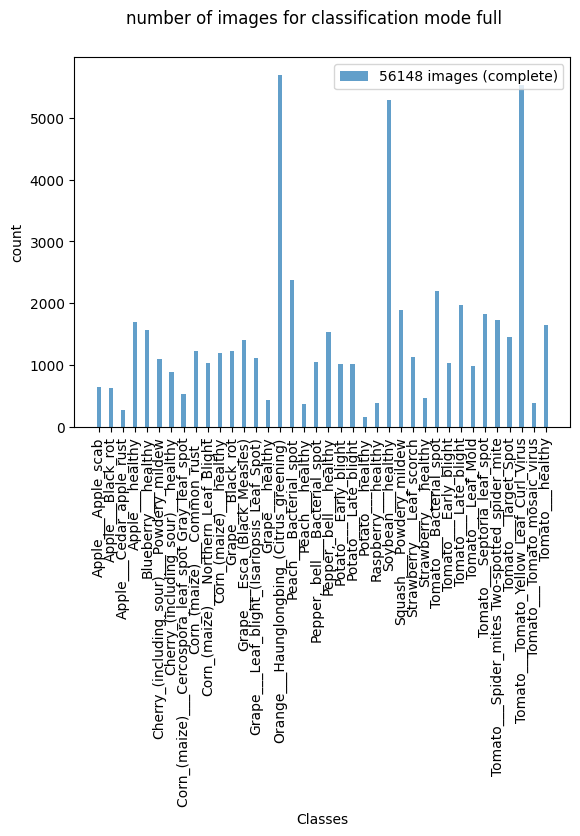

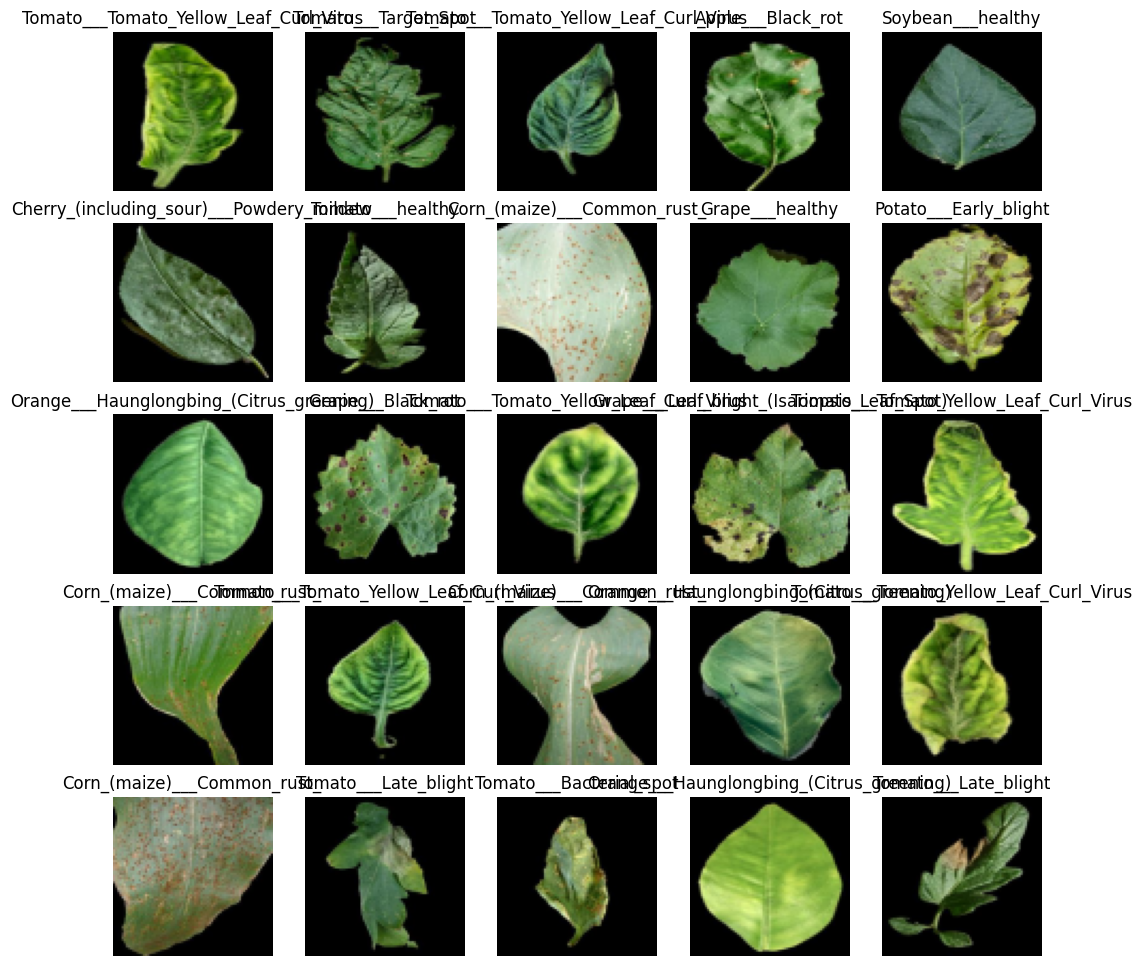

In [4]:
mean, scale = data.get_mean_scale()
data.plot_data_statistics()

In [7]:
import warnings
warnings.filterwarnings('ignore')
import wandb
from wandb.keras import WandbModelCheckpoint
wandb.init(project="ml_survive", entity="hm-muc")


M_leaf_type = Model(width, height, "InceptionV3", 
                    n_classes=38, class_names=data.get_class_names()[0])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.2, patience=2, min_lr=0.0001
        )
checkpoint = WandbModelCheckpoint("models")
early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )
model_leaf_type = M_leaf_type.get_model(lr=0.1, epsilon=0.931538712608992, trainable_layers=0, addtional_layers=0)
leaf_type_history = M_leaf_type.train_model(X_Train, y_Train, X_Valid, y_Valid,
                                                epochs=100, batch_size=32, callbacks=[reduce_lr, early_stopping, checkpoint])

Epoch 1/100
1017/1018 [============================>.] - ETA: 0s - loss: 2.3904 - accuracy: 0.4303

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.9s


1018/1018 [==============================] - 73s 64ms/step - loss: 2.3902 - accuracy: 0.4303 - val_loss: 35.7887 - val_accuracy: 0.0484 - lr: 0.1000
Epoch 2/100
1017/1018 [============================>.] - ETA: 0s - loss: 1.9930 - accuracy: 0.5356

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 1.0s


1018/1018 [==============================] - 66s 63ms/step - loss: 1.9925 - accuracy: 0.5356 - val_loss: 7.2058 - val_accuracy: 0.3346 - lr: 0.1000
Epoch 3/100
1018/1018 [==============================] - ETA: 0s - loss: 1.9426 - accuracy: 0.5238

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 1.0s


1018/1018 [==============================] - 66s 65ms/step - loss: 1.9426 - accuracy: 0.5238 - val_loss: 2.8763 - val_accuracy: 0.3787 - lr: 0.1000
Epoch 4/100
 332/1018 [========>.....................] - ETA: 28s - loss: 1.8102 - accuracy: 0.5147

In [ ]:
# M_leaf_type.save_model("InceptionV3_14_6_64")
# M_leaf_type.save_history("InceptionV3_14_6_64")
M_leaf_type.test_model(X_Test, y_Test)

340/340 [==============================] - 5s 13ms/step
Classification accuracy on test set: 98.1311


array([[4.1101548e-01, 9.8473585e-01, 5.5053812e-01, ..., 4.6453050e-01,
        7.4181557e-01, 5.4399800e-01],
       [7.4047428e-01, 1.3576640e-04, 3.1965280e-01, ..., 8.5183874e-06,
        8.0546014e-02, 1.0000000e+00],
       [1.6007745e-01, 8.2796055e-01, 1.0000000e+00, ..., 4.5052838e-01,
        9.6992582e-01, 3.6402860e-01],
       ...,
       [7.4354839e-01, 6.1601919e-01, 3.4027821e-01, ..., 1.7465405e-02,
        6.4673281e-01, 9.7385490e-01],
       [6.9055147e-02, 4.1839901e-01, 1.6399497e-01, ..., 6.2971100e-02,
        9.2252386e-01, 9.5396560e-01],
       [2.2668757e-01, 1.3285477e-01, 1.9758007e-01, ..., 1.0000000e+00,
        3.5307187e-01, 1.0049882e-03]], dtype=float32)

In [ ]:
wandb.log({
'epoch': len(leaf_type_history.history['loss']), 
'val_accuracy': leaf_type_history.history['val_accuracy'][-1],
'test_accuracy': M_leaf_type.test_accuracy(X_Test, y_Test),
})
wandb.finish()